<a href="https://colab.research.google.com/github/yilewang/TVB_Demo/blob/master/sim1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# %pip install tvb-library
# %pylab inline
import os
from tvb.simulator.lab import *
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetBase, ReducedSetHindmarshRose
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [6]:
# %%capture
# ! wget -c -O 0306A.zip --no-check-certificate https://github.com/yilewang/tvbdemos/raw/master/tvb_slurm/0306A.zip
path = "/Users/yilewang/workspaces/data4project/lateralization/connectome/zip/AD/0306A.zip"

In [7]:
connectivity.speed = np.array([10.])
sim_time = 1e3
ReducedSetBase.number_of_modes = 3
sim = simulator.Simulator(
    model=ReducedSetHindmarshRose(variables_of_interest = ['xi']),
    connectivity=connectivity.Connectivity.from_file(path),             
    coupling=coupling.Linear(a=np.array([0.015])),
    simulation_length=sim_time,
    integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([0.00001]), ntau=0.0,
                                                                                random_stream=np.random.RandomState(seed=42))),
    monitors=(
       monitors.TemporalAverage(period=1.),
       monitors.Raw(),
       monitors.ProgressLogger(period=1e2)
    )
).configure()
sim.configure()

2024-03-18 16:23:31,396 - WARNING - tvb.basic.readers - File 'average_orientations' not found in ZIP.
2024-03-18 16:23:31,397 - WARNING - tvb.basic.readers - File 'cortical' not found in ZIP.
2024-03-18 16:23:31,397 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-03-18 16:23:31,398 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.


In [8]:
(tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()

2024-03-18 16:23:41,282 - INFO - tvb.simulator.monitors - step 1 time 0.0000 s
2024-03-18 16:23:42,454 - INFO - tvb.simulator.monitors - step 8193 time 0.1000 s
2024-03-18 16:23:43,626 - INFO - tvb.simulator.monitors - step 16385 time 0.2000 s
2024-03-18 16:23:44,788 - INFO - tvb.simulator.monitors - step 24577 time 0.3000 s
2024-03-18 16:23:45,966 - INFO - tvb.simulator.monitors - step 32769 time 0.4000 s
2024-03-18 16:23:47,160 - INFO - tvb.simulator.monitors - step 40961 time 0.5000 s
2024-03-18 16:23:48,321 - INFO - tvb.simulator.monitors - step 49153 time 0.6000 s
2024-03-18 16:23:49,509 - INFO - tvb.simulator.monitors - step 57345 time 0.7000 s
2024-03-18 16:23:50,704 - INFO - tvb.simulator.monitors - step 65537 time 0.8000 s
2024-03-18 16:23:51,857 - INFO - tvb.simulator.monitors - step 73729 time 0.9000 s


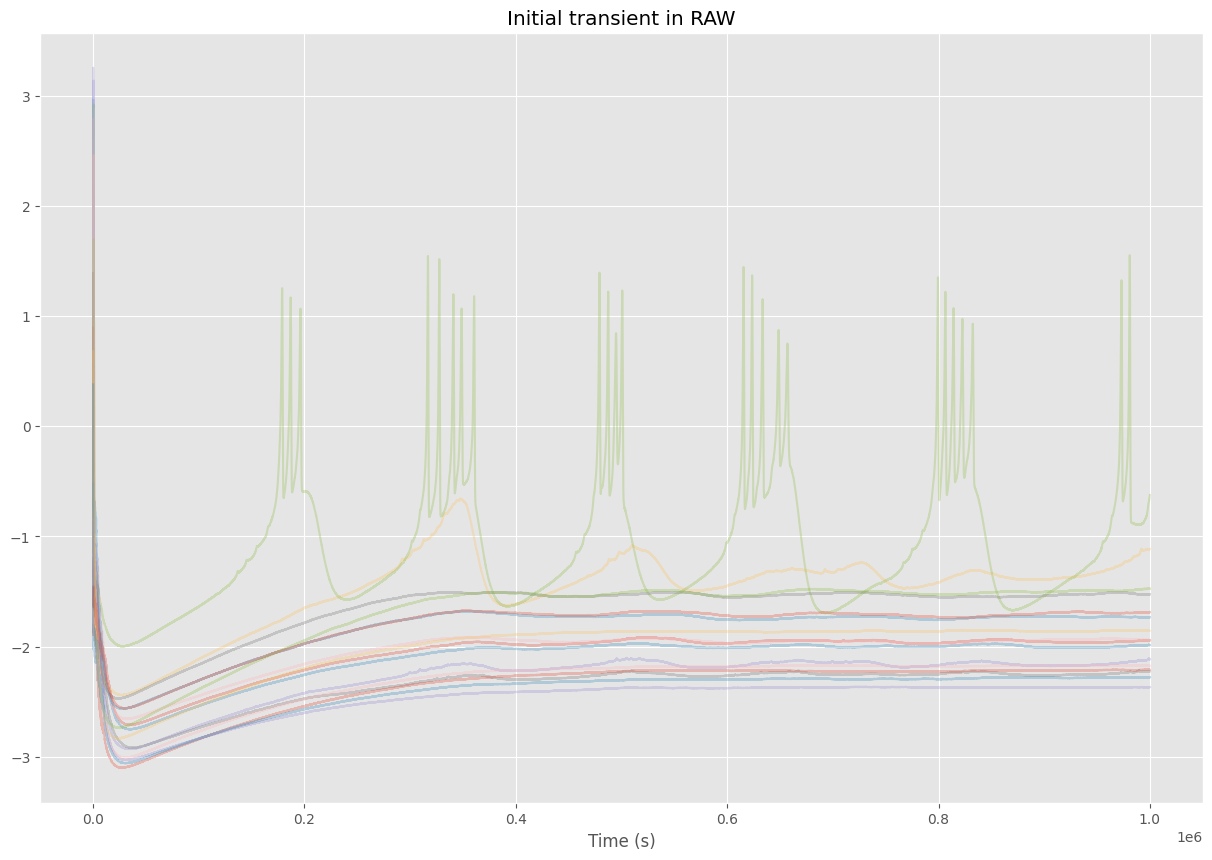

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(raw_time * sim_time, raw_data[:, 0, :, 0], alpha=0.3)
plt.title('Initial transient in RAW')
plt.xlabel('Time (s)')
plt.grid(True);

In [6]:
from scipy import signal
def fir_bandpass(data, fs, cut_off_low, cut_off_high, width=2.0, ripple_db=10.0):
    """
    The FIR bandpass filter
    """
    nyq_rate = fs / 2.0
    wid = width/nyq_rate
    N, beta = signal.kaiserord(ripple_db, wid)
    taps = signal.firwin(N, cutoff = [cut_off_low, cut_off_high],
                  window = 'hamming', pass_zero = False, fs=fs)
    filtered_signal = signal.lfilter(taps, 1.0, data)
    return filtered_signal, N

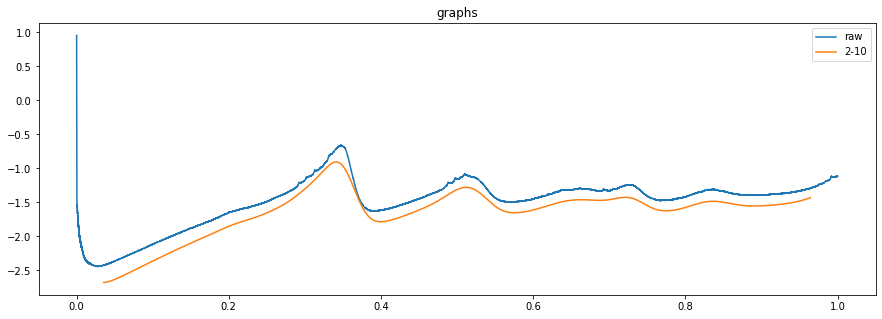

In [7]:
fs = 81920.0
samplinginterval = 1/fs
tt = np.arange(0, 1, samplinginterval)
rightTheta, N = fir_bandpass(raw_data[:,0,4,0], fs, 2.0, 10.0)
rightGamma, N = fir_bandpass(raw_data[:,0,4,0], fs, 30.0, 100)
delay = (N-1)/(2*fs)
# visualization
fig = plt.figure(figsize=(15,5))
plt.title("graphs")
plt.plot(tt, raw_data[:,0,4,0], label = "raw")
# plt.plot(raw_time[N-1:]-delay, rightGamma[N-1:], label = "35-100")
plt.plot(tt[N-1:]-delay, rightTheta[N-1:], label = "2-10")
#plt.axis(xmin=0, xmax=1)
plt.legend()
plt.show()

Text(0, 0.5, 'Frequency')

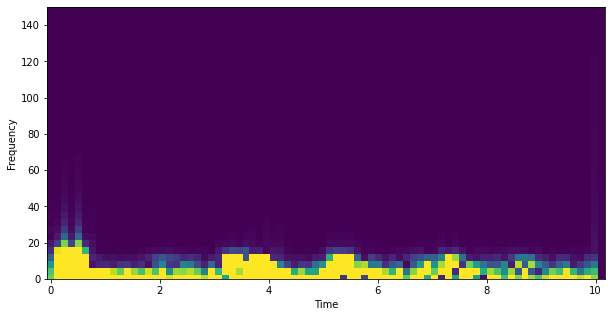

In [8]:
afterRe = signal.resample(rightGamma, 10000)
f, t, Z = signal.stft(afterRe, fs=1000, window='hann', nperseg=256)
Z = np.abs(Z)
plt.figure(figsize = (10,5))
plt.pcolormesh(t, f, Z, vmin = 0, vmax = Z.mean()*10, shading="auto")
plt.axis(ymin=0, ymax=150)
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

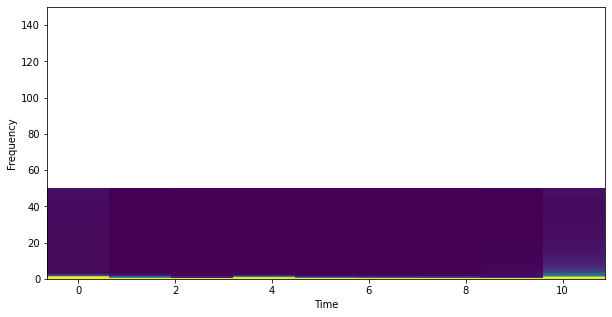

In [9]:
afterRe = signal.resample(rightTheta, 1000)
f, t, Z = signal.stft(afterRe, fs=100, window='hann', nperseg=256)
Z = np.abs(Z)
plt.figure(figsize = (10,5))
plt.pcolormesh(t, f, Z, vmin = 0, vmax = Z.mean()*10, shading="auto")
plt.axis(ymin=0, ymax=150)
plt.xlabel('Time')
plt.ylabel('Frequency')